In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from solver import Solver, LRSchedule

In [2]:
def random_disk(r, nb_points, batch_size=500):
  """Generate nb_points in a disk of radius by rejection sampling. 
  Return shape : (nb_points, 2)."""
  X = np.random.uniform(-r, r, [batch_size, 2])
  X = X[np.linalg.norm(X, axis=1) < r, :]

  while len(X) < nb_points:
    Y = np.random.uniform(-r, r, [batch_size, 2])
    Y = Y[np.linalg.norm(Y, axis=1) < r, :]
    X = np.concatenate([X, Y], axis=0)
  
  return X[:nb_points, :]

def random_crown(r1, r2, nb_points, batch_size=500):
  """Generate nb_points between radiuses r1 and r2 by rejection sampling. 
  Return shape : (nb_points, 2)."""
  X = np.random.uniform(-r2, r2, [batch_size, 2])
  norms = np.linalg.norm(X, axis=1)
  X = X[(r1 < norms) & (norms < r2), :]

  while len(X) < nb_points:
    Y = np.random.uniform(-r2, r2, [batch_size, 2])
    norms = np.linalg.norm(Y, axis=1)
    Y = Y[(r1 < norms) & (norms < r2), :]
    X = np.concatenate([X, Y], axis=0)
  
  return X[:nb_points, :]

def random_circle(r, nb_points):
  """Generate nb_points on the circle of radius r 
  centered at (0,0). 
  Return shape : (nb_points, 2)."""
  Y = np.random.normal(size=[nb_points, 2])
  return r * Y / np.linalg.norm(Y, axis=1)[:, np.newaxis]

We consider two concentric circular conductors (radii $r_1$, $r_2$) set at potential 1 and 0. The exact solution is constant equal to 1 inside the inner conductor, so we only compute the solution between the interface of both conductors.

In [3]:
r1 = 0.5  # inner disk radius
r2 = 1.  # outer disk radius

nb_col = 10000
nb_bound = 1000
nb_train_col = 9000
nb_train_bound = 800
ratio = r1 / r2
nb_ext = int(nb_bound / (1 + ratio))
nb_int = nb_bound - nb_ext

# outer circle
boundary = random_circle(r2, nb_ext)
# adding inner circle
boundary = np.concatenate([boundary, 
                           random_circle(r1, nb_int)], axis=0)
boundary_cond = np.ones(nb_bound)
boundary_cond[:nb_ext] = 0.  # set the outer circle to zero potential 

collocation = random_crown(r1, r2, nb_col)

perm_col = np.random.permutation(nb_col)
perm_bound = np.random.permutation(nb_bound)
boundary, collocation = boundary[perm_bound, :], collocation[perm_col, :]
boundary_cond = boundary_cond[perm_bound].reshape(-1, 1)

# test and train data
boundary_train = tf.Variable(boundary[:nb_train_bound, :], dtype=tf.float32)
collocation_train = tf.Variable(collocation[:nb_train_col, :], dtype=tf.float32)
boundary_cond_train = tf.Variable(boundary_cond[:nb_train_bound, :], dtype=tf.float32)

boundary_test = tf.Variable(boundary[nb_train_bound:, :], dtype=tf.float32)
collocation_test = tf.Variable(collocation[nb_train_col:, :], dtype=tf.float32)
boundary_cond_test = tf.Variable(boundary_cond[nb_train_bound:, :], dtype=tf.float32)

In [4]:
def poisson_fun(v_fun, x, y, training=False):
  with tf.GradientTape(persistent=True) as g2:
    g2.watch(x), g2.watch(y)
    with tf.GradientTape(persistent=True) as g1:
      g1.watch(x), g1.watch(y)
      v = v_fun(x, y, training=training)
    v_x = g1.gradient(v, x)
    v_y = g1.gradient(v, y)
  v_xx = g2.gradient(v_x, x)
  v_yy = g2.gradient(v_y, y)

  return v_xx + v_yy

def dirichlet_cond(v_fun, x, y, training=False):
  return v_fun(x, y, training=training)

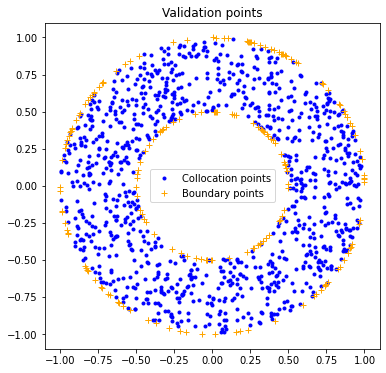

In [5]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(collocation_test[:,0], collocation_test[:, 1], '.', color='blue', label='Collocation points')
ax.plot(boundary_test[:,0], boundary_test[:, 1], '+', color='orange', label='Boundary points')
ax.legend()
ax.set_title('Validation points');

In [6]:
monitor = LRSchedule(decay_factor=0.5, patience=50, restore_best=True)
solver = Solver(collocation_test, boundary_test, boundary_cond_test, poisson_fun, lr_sch=monitor, dropout=0, lr=0.01)

solver.train(20000, collocation_train, boundary_train, boundary_cond_train, verbose=True)

019293641671538 --- val_loss : 0.00016862674965523183 -- lr : 1e-05
epoch 19819/20000 --- train_loss : 0.00015017989790067077 --- val_loss : 0.00016797006537672132 -- lr : 1e-05
epoch 19820/20000 --- train_loss : 0.00015016105317045003 --- val_loss : 0.0001686195464571938 -- lr : 1e-05
epoch 19821/20000 --- train_loss : 0.00015012026415206492 --- val_loss : 0.00016795459669083357 -- lr : 1e-05
epoch 19822/20000 --- train_loss : 0.00015006164903752506 --- val_loss : 0.00016828473599161953 -- lr : 1e-05
epoch 19823/20000 --- train_loss : 0.00015000393614172935 --- val_loss : 0.00016811290697660297 -- lr : 1e-05
epoch 19824/20000 --- train_loss : 0.00014995934907346964 --- val_loss : 0.0001679306587902829 -- lr : 1e-05
epoch 19825/20000 --- train_loss : 0.0001499291101936251 --- val_loss : 0.00016825667989905924 -- lr : 1e-05
epoch 19826/20000 --- train_loss : 0.0001499039790360257 --- val_loss : 0.00016775200492702425 -- lr : 1e-05
epoch 19827/20000 --- train_loss : 0.0001498729689046740

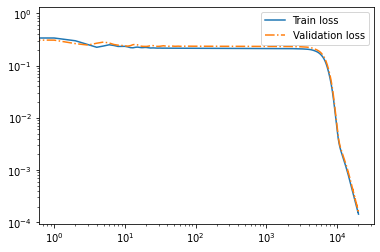

In [7]:
plt.loglog(solver.train_history, label='Train loss')
plt.loglog(solver.val_history, '-.', label='Validation loss')
plt.legend();

In [8]:
v1 = 0
v0 = 1

def solution(x, y):
        # theoretical exact solution to the PDE
        r = np.sqrt(x ** 2 + y ** 2)
        ct1 = (v1 - v0) / np.log(r2 / r1)
        ct2 = v0 - np.log(r1) * ct1
        ct3 = ct1
        ct4 = v1 - np.log(r2) * ct3
        return (r <= r1)*v0 + ((r > r1) & (r < r2))*(ct3*np.log(r) + ct4) + (r > r2)*v1

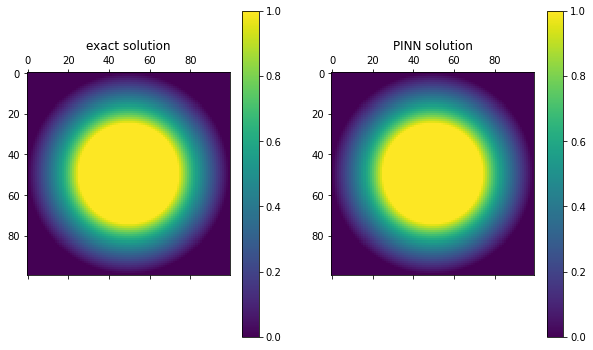

In [9]:
# plotting exact and PINN solution
# the PINN solution is not expected to be accurate in the inner disk (should be constant =1)
XX, YY = np.meshgrid(np.linspace(-r2, r2, 100), np.linspace(-r2, r2, 100))
ZZ = np.concatenate([XX.reshape(-1, 1), YY.reshape(-1, 1)], 1)
ind = np.linalg.norm(ZZ, axis=1) < r2
ZZ = ZZ[ind, :]
x, y = ZZ[:, 0].reshape(-1, 1), ZZ[:, 1].reshape(-1, 1)
res = solution(x, y)
full_res = np.zeros(len(XX)**2)
full_res[ind] = res.flatten()
full_res = full_res.reshape(100, 100)

num = solver.v(x, y).numpy()
full_num = np.zeros(len(XX)**2)
full_num[ind] = num.flatten()
full_num = full_num.reshape(100, 100)

fig, ax = plt.subplots(1, 2, figsize=(10,6))
im1 = ax[0].matshow(full_res, vmax=1, vmin=0)
im2 = ax[1].matshow(full_num, vmax=1, vmin=0)
fig.colorbar(im1, ax=ax[0])
fig.colorbar(im2, ax=ax[1])
ax[0].set_title('exact solution')
ax[1].set_title('PINN solution');

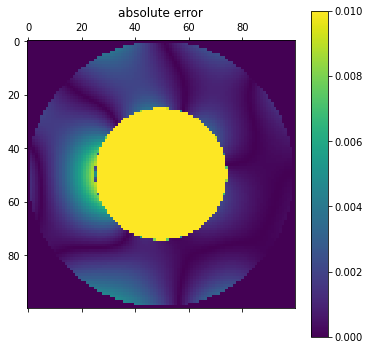

In [18]:
# the NN predicts a potential over 1 in the inner disk (no training points)
err = np.abs(full_num-full_res)

fig, ax = plt.subplots(figsize=(6,6))
im1 = ax.matshow(err, vmax=1e-2, vmin=0)
fig.colorbar(im1, ax=ax)
ax.set_title('absolute error');